📌 التعرف على اليد باستخدام MediaPipe (Computer Vision):

 Install Required Libraries ✈

In [ ]:
!pip install mediapipe opencv-python

🏗️ Hand Detection Test

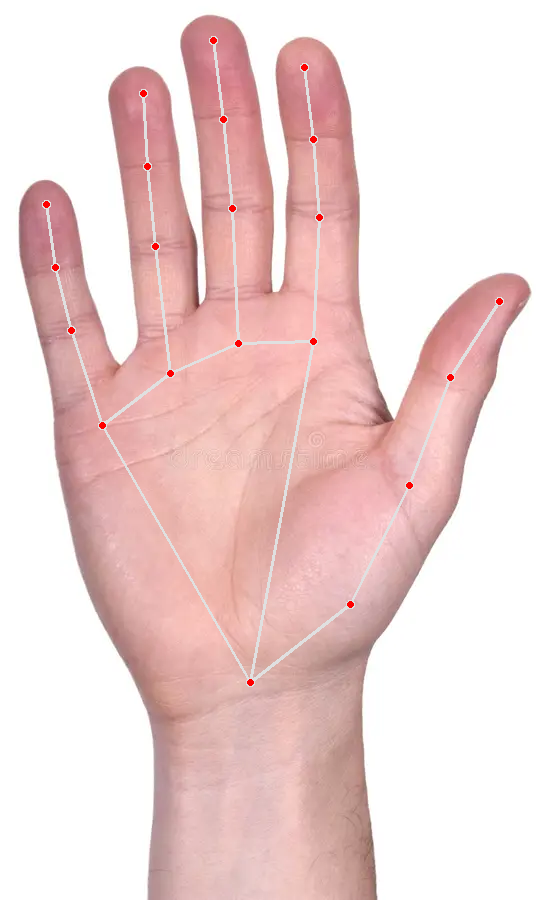

In [ ]:
import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow


image_path = '/content/hand_sample.jpg'
image = cv2.imread(image_path)

# تشغيل MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True)
results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp.solutions.drawing_utils.draw_landmarks(
            image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

cv2_imshow(image)



Download Dataset from Kaggle

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghalaalrajhi","key":"e71d76a76c41297ee3ca5b6f5b837b4f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download Arabic Sign Language Dataset from Kaggle
!kaggle datasets download -d muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset

!unzip -q rgb-arabic-alphabets-sign-language-dataset.zip -d arabic_sign_dataset

# Confirm Dataset Folders
import os
arabic_dir = '/content/arabic_sign_dataset'
print("مجلدات البيانات:", os.listdir(arabic_dir))


Dataset URL: https://www.kaggle.com/datasets/muhammadalbrham/rgb-arabic-alphabets-sign-language-dataset
License(s): CC-BY-SA-4.0
100% 4.72G/4.72G [00:56<00:00, 230MB/s]
100% 4.72G/4.72G [00:56<00:00, 90.3MB/s]
مجلدات البيانات: ['RGB ArSL dataset']


Visualize Sample Images

عدد الحروف: 31
أسماء الحروف: ['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf', 'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal', 'Theh', 'Waw', 'Yeh', 'Zah', 'Zain']


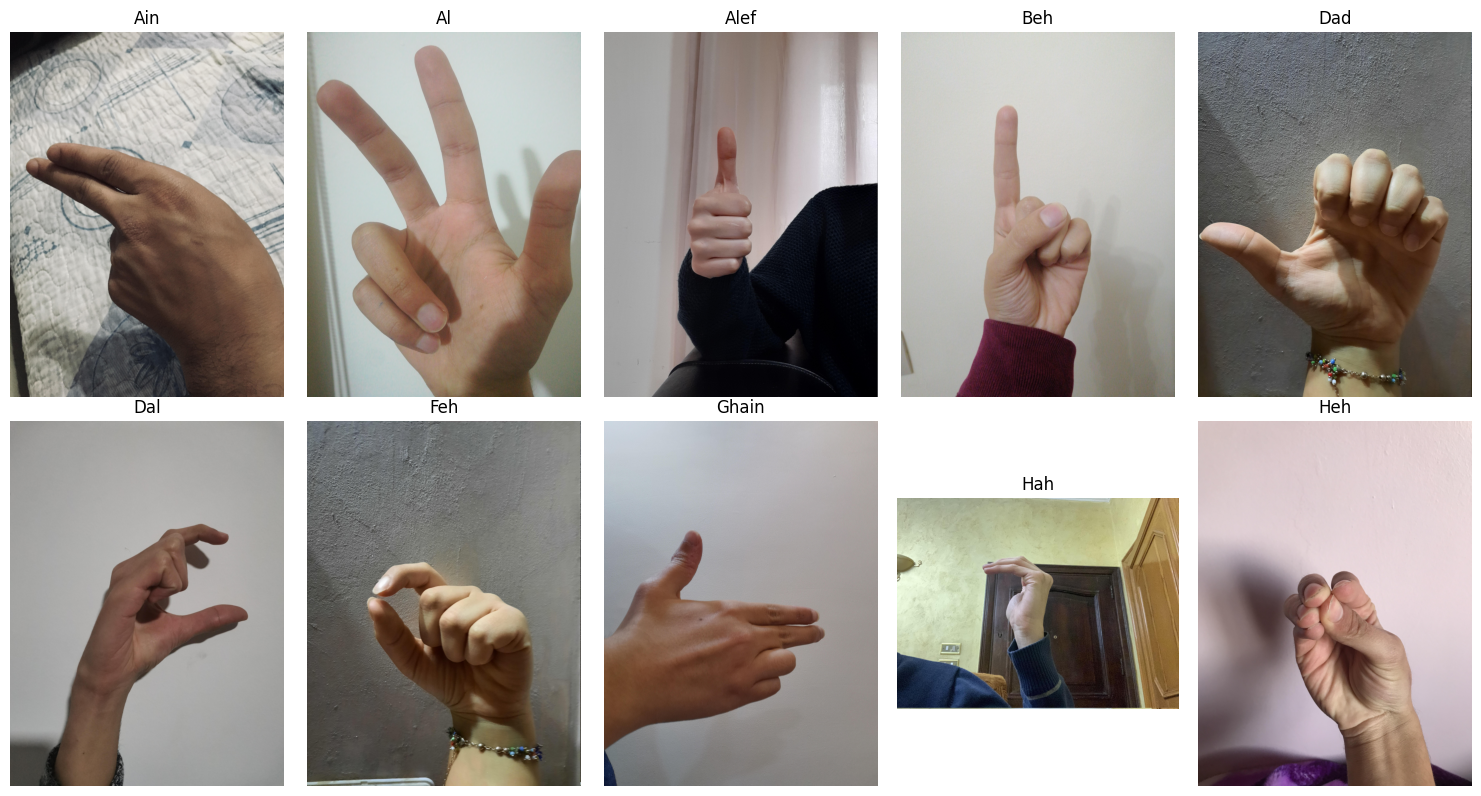

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Show Sample Images for Each Class
dataset_path = '/content/arabic_sign_dataset/RGB ArSL dataset'

class_names = sorted(os.listdir(dataset_path))
print("عدد الحروف:", len(class_names))
print("أسماء الحروف:", class_names)

plt.figure(figsize=(15, 8))

for i, class_name in enumerate(class_names[:10]):
    class_dir = os.path.join(dataset_path, class_name)
    image_name = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, image_name)

    # check for photo
    if not os.path.exists(img_path):
        print(f"الصورة غير موجودة: {img_path}")
        continue

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install tensorflow tqdm


Prepare Data for Training

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


dataset_path = "/content/arabic_sign_dataset/RGB ArSL dataset"
categories = sorted(os.listdir(dataset_path))

print(f"عدد الحروف: {len(categories)}")
print(f"أسماء الحروف: {categories}")


data = []
labels = []
img_size = 64

for category in tqdm(categories, desc="Loading images"):
    category_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(category)

# تحويل الصور إلى numpy array وتطبيعها
X = np.array(data, dtype='float32') / 255.0
y = np.array(labels)

# تحويل النصوص إلى أرقام
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# تحويل التصنيفات إلى صيغة one-hot
y_categorical = to_categorical(y_encoded)

# Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"أشكال البيانات: \nX_train: {X_train.shape}, y_train: {y_train.shape}\nX_test: {X_test.shape}, y_test: {y_test.shape}")


عدد الحروف: 31
أسماء الحروف: ['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh', 'Jeem', 'Kaf', 'Khah', 'Laa', 'Lam', 'Meem', 'Noon', 'Qaf', 'Reh', 'Sad', 'Seen', 'Sheen', 'Tah', 'Teh', 'Teh_Marbuta', 'Thal', 'Theh', 'Waw', 'Yeh', 'Zah', 'Zain']


Loading images: 100%|██████████| 31/31 [05:39<00:00, 10.95s/it]


أشكال البيانات: 
X_train: (6284, 64, 64, 3), y_train: (6284, 31)
X_test: (1572, 64, 64, 3), y_test: (1572, 31)


🧠Build CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(categories), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 687,199 (2.62 MB)

 Trainable params: 687,199 (2.62 MB)

 Non-trainable params: 0 (0.00 B)

 🏗️ Train the Model

In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.0357 - loss: 3.4369 - val_accuracy: 0.0420 - val_loss: 3.4170
Epoch 2/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0581 - loss: 3.3796 - val_accuracy: 0.1775 - val_loss: 2.9518
Epoch 3/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1781 - loss: 2.8878 - val_accuracy: 0.3028 - val_loss: 2.4867
Epoch 4/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3078 - loss: 2.3730 - val_accuracy: 0.3594 - val_loss: 2.1115
Epoch 5/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3845 - loss: 2.0012 - val_accuracy: 0.4256 - val_loss: 1.9315
Epoch 6/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4827 - loss: 1.7010 - val_accuracy: 0.4835 - val_loss: 1.7391
Epoch 7/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5422 - loss: 1.4657 - val_accuracy: 0.5038 - val_loss: 1.6543
Epoch 8/10
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6054 - loss: 1.2377 - val_accuracy: 

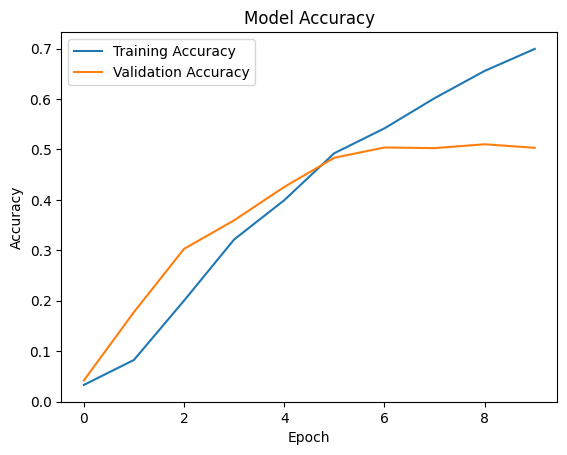

In [ ]:
import matplotlib.pyplot as plt
# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Save and Load Model for Live Camera Use

In [ ]:
# Save the Model
model.save('arabic_sign_language_model.h5')

# Load the Model
model = load_model('/content/arabic_sign_language_model.h5')


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
import base64
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📷 Capture Photo';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# ✅ Test Camera
filename = take_photo()
print(f"Saved to {filename}")
img = cv2.imread(filename)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


<p align="center">
  <img src="https://i.imgur.com/embH4HC.png" width="800">
</p>
